Features

In [1]:
# lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')

# homemade
from features import tautil, sadf, trnd_scan, microstructure_features

In [36]:
import warnings
warnings.filterwarnings(action='ignore')

In [37]:
mtd_data = pd.read_excel('C:data/mtd_data.xlsx')
date = mtd_data.iloc[:,1].rename('Date')
open = mtd_data.iloc[:,2].rename('open')
high = mtd_data.iloc[:,3].rename('high')
low = mtd_data.iloc[:,4].rename('low')
close = mtd_data.iloc[:,5].rename('close')
volume = mtd_data.iloc[:,6].rename('volume')

In [38]:
df = pd.DataFrame([open,high,low,close,volume]).T
df.index=date

In [39]:
#import FinanceDataReader as fdr
#import yfinance as yf
#df_ohlc = fdr.DataReader('005930','2005-7-27','2022-1-17').iloc[:,0:4] #가격 수정되어 있음
#volume_yf = yf.download('005930.KS','2005-7-27','2022-1-17',auto_adjust=True).Volume # 수정거래량
#df_ohlcv = df_ohlc.join(volume_yf).dropna()
#df = tautil.ohlcv(df_ohlcv)

In [40]:
quantity_ = pd.read_csv('C:data/순매수량.csv')
quantity_ = quantity_.iloc[:-1,1:5]
quantity_.columns = ['Date','individual','foreign','institutional']
quantity_.index = quantity_['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
quantity_.drop(columns='Date',inplace=True)
df = df.join(quantity_).dropna()

In [41]:
df.to_csv("C:data/market_samsung.csv")
df

,open,high,low,close,volume,individual,foreign,institutional
Date,,,,,,,,
2005-07-27,11040,11180,10960,11020,18434300,-2543250.0,-1411300.0,-1210850.0
2005-07-28,11040,11320,11040,11200,23659800,-2067600.0,3772300.0,-1517250.0
2005-07-29,11320,11320,11200,11300,17875500,1583050.0,796450.0,-1843600.0
2005-08-01,11320,11380,11220,11380,16471100,-3111550.0,1520100.0,-2652100.0
2005-08-02,11400,11420,11240,11360,14254000,-1567950.0,-1895300.0,-1310950.0
...,...,...,...,...,...,...,...,...
2021-10-08,72300,72400,71500,71500,14043287,2612855.0,319900.0,-2923031.0
2021-10-12,70700,70900,68700,69000,31001484,12155071.0,-11004329.0,-1421202.0
2021-10-13,68700,69600,68300,68800,24172015,2224620.0,-5271845.0,2725596.0


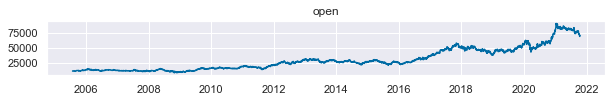

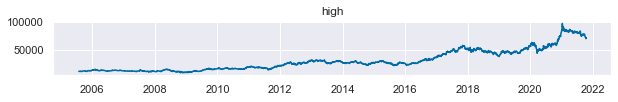

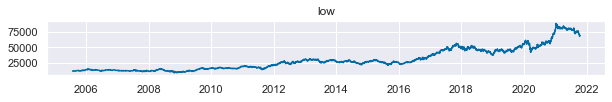

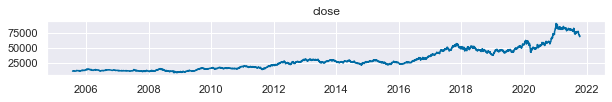

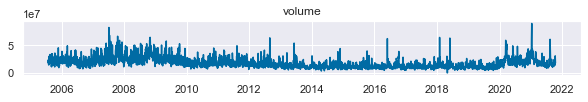

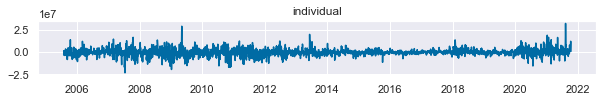

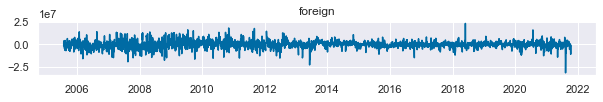

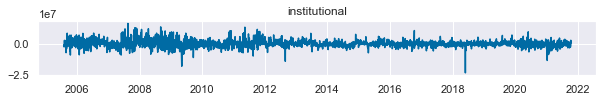

In [42]:
for i in df.columns:
    plt.figure(figsize=(10,1))
    plt.title(i)
    plt.plot(df[i])

# Feature


- 14개의 기술적분석 지표
    - RSI 15
    - Willams's R 15
    - ADX 15          
    - AROON Indicator 20      
    - DPO 20    
    - MACD Difference (25,10,9)
    - Mass Index (10, 25)
    - TRIX 15
    - ATR 10
    - UI 15 
    - CMF 20
    - FI 15
    - MFI 15 
    - EOM SMA 15
    - VPT
- 5,10,20일 기간의 가격 수익률
- 30일 기간의 가격 변동성(표준편차)
- 개인, 기관, 외국인 별 순매수량의 5일,  20일
- 트렌드-스캐닝 백워드 t value span = 20,60
- 미시구조론 변수 각 20일 이동평균
    - kyle_lambda          
    - amihud_lambda         
    - hasbrouck_lambda      
    - bekker_parkinson_volatility
    - corwin_schultz_estimator 


In [43]:
windows_TA = [1]
TA = tautil.get_my_stationary_ta_windows(df_ohlcv,windows_TA).dropna()

In [44]:
windows_mom = [5,10,20]
windows_std = [30]

moms = tautil.mom_std(df,windows_mom, windows_std)
moms = moms.iloc[:,:len(windows_mom)+len(windows_std)]

In [45]:
quantity_ = pd.read_csv('C:data/순매수량.csv')
quantity_ = quantity_.iloc[:-1,1:5]
quantity_.columns = ['Date','individual','foreign','institutional']
quantity_.index = quantity_['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
quantity_.drop(columns='Date',inplace=True)

In [46]:
windows_ma=[5,20]
for i in quantity_.columns:
    for j in windows_ma:
        quantity_['{} sma_{}'.format(i,j)] = quantity_[i].rolling(j).mean()
        quantity_.dropna(inplace=True)
quantity = quantity_.iloc[:,3:]

In [47]:
spans = [20,60]
trnd_back = pd.DataFrame()
for span in spans:
    trnd_back['trend_back_scan_{}'.format(span)] = trnd_scan.trend_backward_scanning(df.close, span).t_value

In [48]:
dollar_volume = df.volume*df.close

In [49]:
close=df.close
kyle = microstructure_features.get_bar_based_kyle_lambda(close, df.volume, 20).rename('kyle_lambda')
amihud = microstructure_features.get_bar_based_amihud_lambda(close, dollar_volume, 20).rename('amihud_lambda')
hasbrouk = microstructure_features.get_bar_based_hasbrouck_lambda(close, dollar_volume,20).rename('hasbrouck_lambda')
bp_vol = microstructure_features.get_bekker_parkinson_vol(df.high,df.low,20).rename('bekker_parkinson_vol')
corsch = microstructure_features.get_corwin_schultz_estimator(df.high,df.low,20).rename('corwin_schultz_estimator')

In [50]:
microstructure = pd.concat([kyle,amihud,hasbrouk,bp_vol,corsch],axis=1)

In [51]:
features = TA.join([moms,quantity,trnd_back,microstructure]).dropna()
features.to_csv('C:data/features_samsung.csv')

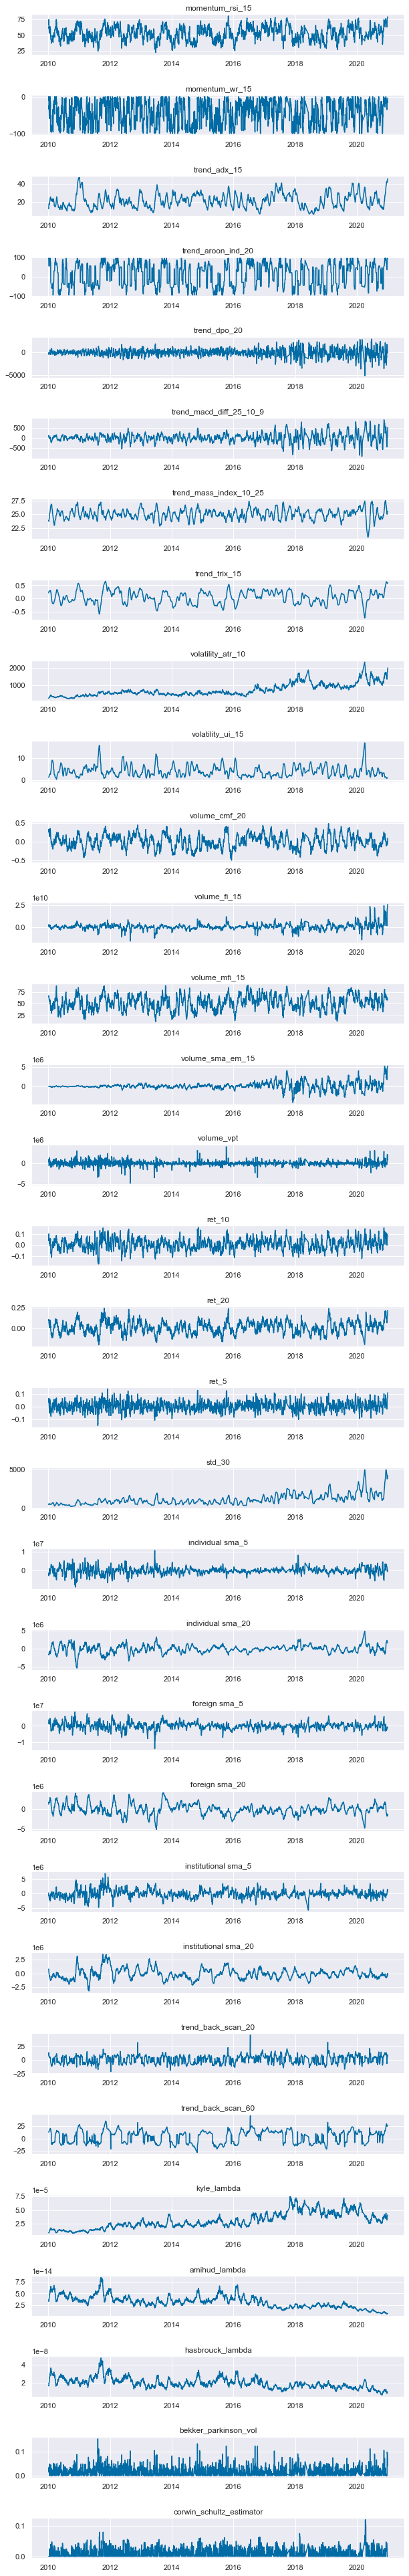

In [73]:
features = features['2010':'2020']
f, axs = plt.subplots(len(features.T),figsize=(10,70),gridspec_kw={'hspace': 1})
for i in range(len(features.T)):
    axs[i].title.set_text(features.columns[i])
    axs[i].plot(features.iloc[:,i])
f.savefig('C:image/features.png')